##### Copyright 2024 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.data import Dataset
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score

import random
from scipy import stats

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


       0/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 4202496/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

11640832/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

16785408/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


   0/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


      0/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [3]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [5]:
history = autoencoder.fit(x_train, 
                x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0405

KeyboardInterrupt: 

 380/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0734

 428/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0704

 477/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0677

 525/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0654

 573/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0634

 621/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0615

 669/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0599

 718/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0583

 765/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0570

 813/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0557

 861/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0545

 908/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0534

 956/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0524

1005/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0514

1053/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0505

1102/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0496

1150/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0488

1199/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0480

1248/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0473

1296/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0466

1344/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0460

1392/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0453

1441/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0447

1490/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0441

1537/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0436

1584/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0431

1631/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0426

1679/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0421

1726/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0416

1774/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0412

1821/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0407

1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0403

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0403 - val_loss: 0.0132


Epoch 2/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:33 50ms/step - loss: 0.0129

  42/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0134   

  88/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0133

 137/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132

 185/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131

 234/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131

 282/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131

 330/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130

 378/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130

 426/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129

 474/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129

 522/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129

 570/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128

 618/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128

 666/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128

 714/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128

 762/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127

 809/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127

 855/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127

 902/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127

 949/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

 994/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1039/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1086/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1133/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126

1180/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1228/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1275/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1322/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1370/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125

1417/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124

1464/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124

1511/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124

1558/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124

1606/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124

1651/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124

1695/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123

1742/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123

1789/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123

1836/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0123 - val_loss: 0.0106


Epoch 3/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:24 45ms/step - loss: 0.0087

  47/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103   

  94/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 141/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 188/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 235/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 282/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 328/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 375/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104

 421/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 467/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 514/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 561/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 607/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 654/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 701/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 748/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 795/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 842/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 890/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 937/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0103

 983/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1030/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1076/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1123/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1169/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103

1215/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1261/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1309/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1356/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1404/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1451/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1496/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1542/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1588/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1635/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1682/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1729/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1776/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1824/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0102 - val_loss: 0.0097


Epoch 4/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:26 46ms/step - loss: 0.0095

  48/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097   

  97/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097

 146/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097

 194/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097

 243/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 291/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 339/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 389/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 438/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 487/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 536/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 584/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 632/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 680/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 728/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096

 777/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 825/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 873/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095

 922/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

 972/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1020/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1069/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1118/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1167/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1217/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1266/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1314/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1362/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1411/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1460/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1508/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1556/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1604/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1653/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1702/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1751/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1799/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0095 - val_loss: 0.0093


Epoch 5/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0093

  47/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0090   

  95/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091

 144/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091

 193/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 241/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 288/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 335/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 383/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 430/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 477/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 524/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 570/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 615/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 662/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 710/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 758/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 805/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 851/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 897/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092

 945/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

 992/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1039/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1088/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1136/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1184/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1231/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1279/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1328/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1376/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1424/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1472/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1520/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1569/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1616/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1662/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1710/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1759/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1808/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092 - val_loss: 0.0093


Epoch 6/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0087

  46/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0091   

  93/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091

 140/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091

 187/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091

 235/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 283/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 331/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 378/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 425/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 471/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 518/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 566/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 614/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 662/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 710/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 758/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 804/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 848/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 893/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 938/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090

 983/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1030/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1077/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1121/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1166/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1211/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1256/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1301/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1347/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1393/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1438/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1484/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1530/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1576/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1623/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1670/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1714/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1759/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1803/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0090 - val_loss: 0.0090


Epoch 7/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:28 47ms/step - loss: 0.0079

  45/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088   

  91/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088

 136/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 181/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 228/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 274/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 321/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 367/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 411/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 456/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 500/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 545/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 591/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 636/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 681/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 727/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 774/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 821/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 868/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 915/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 962/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

1010/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1056/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1103/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1150/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1198/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1245/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1292/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1339/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1384/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1430/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1476/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1521/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1567/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1611/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1656/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1701/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1746/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1791/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1836/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088 - val_loss: 0.0090


Epoch 8/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0081

  45/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088   

  89/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089

 133/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089

 178/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089

 224/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089

 270/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089

 316/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089

 362/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089

 409/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 457/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 503/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 550/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 595/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 640/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 685/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 732/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 778/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 825/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 870/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 916/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 958/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

1001/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1044/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1089/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1134/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1178/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1224/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1270/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1318/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1366/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1413/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1462/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1510/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1557/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1605/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1651/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1696/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1740/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1785/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1830/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088 - val_loss: 0.0089


Epoch 9/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0075

  46/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088   

  93/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 139/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 186/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087

 233/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 281/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 327/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 375/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 422/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 469/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 515/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 561/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 607/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 654/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 702/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 750/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 798/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 845/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 893/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 941/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088

 989/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1036/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1081/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1128/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1175/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1223/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1271/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1318/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1366/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1413/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1459/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1504/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1549/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1592/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1635/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1682/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1730/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1777/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1824/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088 - val_loss: 0.0088


Epoch 10/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:27 47ms/step - loss: 0.0086

  48/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085   

  95/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 142/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 187/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 234/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 281/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 327/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 374/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 421/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 468/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 515/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 562/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 610/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 656/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 702/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 750/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 797/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 846/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 893/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 940/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086

 987/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086

1035/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1082/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1130/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1178/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1225/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1272/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1318/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1361/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1405/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1450/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1496/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1543/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1591/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1639/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1687/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1735/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1784/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1833/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087 - val_loss: 0.0088


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [3]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

NameError: name 'autoencoder' is not defined

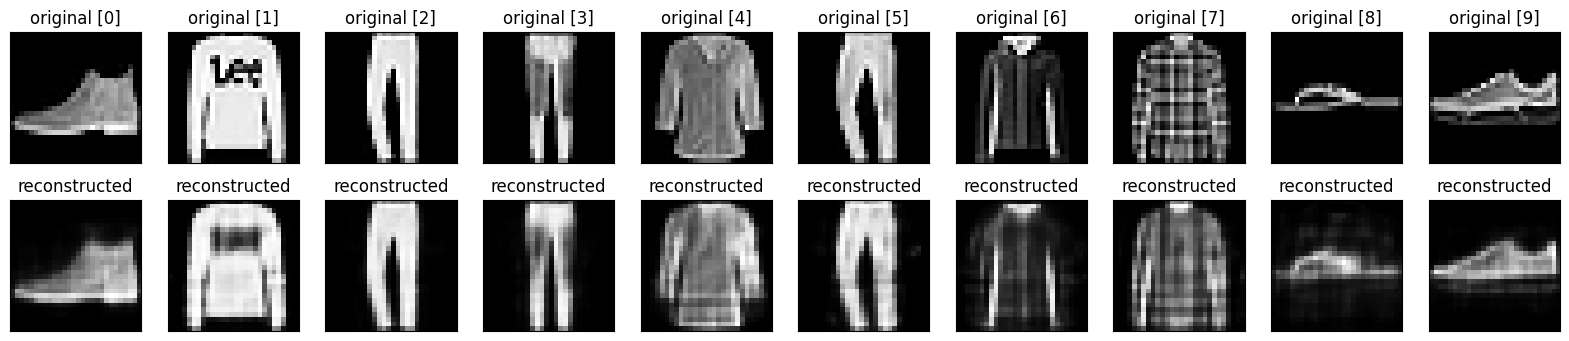

In [8]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title(f"original [{i}]")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [4]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Adding random noise to the images

In [17]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [19]:
# create the dataset with batch size equal to 32
batch_size = 32
train_ds = Dataset.from_tensor_slices((x_train_noisy, x_train))    # input noised image, output clear image
train_ds = train_ds.shuffle(buffer_size=len(x_train_noisy))
train_ds = train_ds.batch(batch_size)

Plot the noisy images.


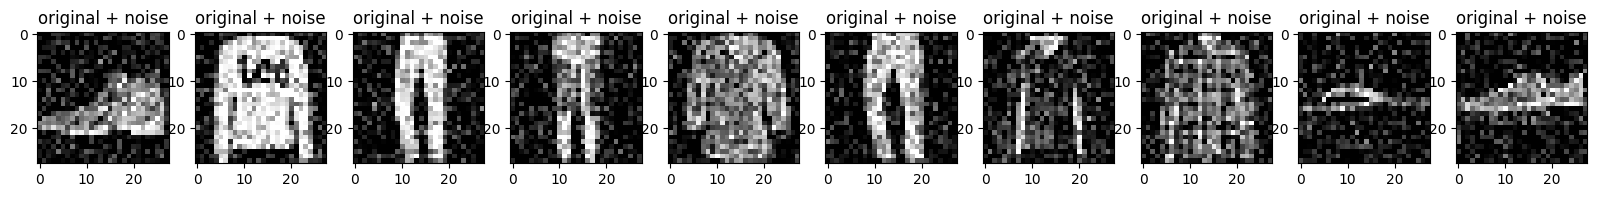

In [20]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [21]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [34]:
autoencoder.compile(optimizer='adam', 
                    loss=losses.MeanSquaredError(), 
                    metrics=[RootMeanSquaredError])

In [35]:
history = autoencoder.fit(train_ds,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0830
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828
Epoch 7/10
1875/1875 ━━━━━━━

 441/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0793

 474/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0766

 508/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0740

 542/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0716

 577/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0694

 611/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0675

 644/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0657

 678/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0640

 712/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0624

 746/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0610

 780/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0596

 814/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0583

 848/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0571

 882/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0560

 916/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0549

 951/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0539

 986/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0529

1021/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0520

1056/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0511

1090/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0503

1123/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0496

1157/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0488

1191/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0481

1226/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0474

1261/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0467

1295/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0461

1330/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0455

1364/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0449

1398/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0444

1432/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0438

1466/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0433

1500/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0428

1534/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0424

1568/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0419

1602/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0414

1636/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0410

1670/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0406

1704/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0402

1738/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0398

1772/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0394

1805/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0391

1840/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0387

1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0383

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0383 - val_loss: 0.0111


Epoch 2/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:28 47ms/step - loss: 0.0125

  33/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0112   

  65/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0111

  97/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0110

 130/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0110

 163/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0110

 196/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0110

 229/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0110

 262/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0110

 294/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 327/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 360/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 393/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 426/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 458/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 490/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 522/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 555/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 588/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109

 621/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109

 653/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109

 685/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109

 718/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109

 750/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

 782/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

 815/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

 848/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

 881/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

 913/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

 944/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

 975/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1006/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1037/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1068/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1099/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1129/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1159/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1189/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1219/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108

1249/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108

1279/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108

1310/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108

1340/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108

1369/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1399/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1431/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1462/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1492/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1522/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1552/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1582/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1611/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1640/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1670/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1700/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1730/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1760/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1790/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1821/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0107 - val_loss: 0.0099


Epoch 3/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0105

  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097   

  58/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097

  86/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097

 115/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097

 144/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097

 173/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0098

 202/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 230/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 258/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 286/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 315/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 344/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 373/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 402/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 431/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 459/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 488/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 517/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 545/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 574/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 603/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 631/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 661/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 691/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 721/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098

 751/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

 781/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

 810/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

 838/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

 867/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

 895/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

 923/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

 952/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

 980/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1009/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1037/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1065/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1093/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1121/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1150/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1178/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1206/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1234/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1262/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1289/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098

1317/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098

1345/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098

1373/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098

1401/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098

1429/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098

1457/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098

1486/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098

1514/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1542/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1570/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1598/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1626/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1655/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1683/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1712/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1740/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1768/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1796/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1824/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0097 - val_loss: 0.0094


Epoch 4/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:27 47ms/step - loss: 0.0084

  28/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094   

  55/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094

  82/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094

 109/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094

 136/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094

 163/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094

 190/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094

 217/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094

 244/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094

 272/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094

 299/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094

 326/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094

 353/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094

 380/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 407/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 435/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 463/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 491/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 519/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 547/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 575/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 603/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 631/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 659/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 687/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 714/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 742/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 770/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093

 797/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

 825/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

 853/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

 880/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

 907/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

 934/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

 962/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

 990/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1018/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1046/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1074/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1102/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1130/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1158/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1186/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1214/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1242/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1270/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1297/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1325/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093

1353/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1381/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1409/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1436/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1464/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1492/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1520/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1547/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1575/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1602/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1630/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1658/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1686/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1714/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1742/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1770/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1798/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1826/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0093 - val_loss: 0.0091


Epoch 5/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0100

  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0093   

  60/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0092

  89/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0092

 119/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091

 149/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0091

 178/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0091

 207/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0091

 236/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0091

 266/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0091

 296/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 326/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 355/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 384/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 413/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 442/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 472/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 501/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 530/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 560/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 589/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 619/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 649/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 678/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 707/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090

 737/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090

 767/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090

 796/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090

 825/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090

 855/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090

 884/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090

 914/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090

 944/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090

 974/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1004/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1033/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1062/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1091/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1121/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1151/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1182/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1212/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1243/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1273/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089

1303/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1334/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1363/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1393/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1423/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1453/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1484/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1514/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1544/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1574/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1603/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1633/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1663/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1693/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1723/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1753/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1783/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1813/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0089 - val_loss: 0.0087


Epoch 6/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:26 46ms/step - loss: 0.0085

  31/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0086   

  62/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0086

  93/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0086

 123/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0086

 153/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0086

 183/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0086

 213/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 243/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 273/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 303/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 333/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 363/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 393/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 423/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 453/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 483/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 513/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 543/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 573/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 603/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 632/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 662/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 692/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085

 722/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 752/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 782/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 812/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 842/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 872/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 902/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 932/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 962/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

 992/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1022/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1052/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1082/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1112/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1142/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1172/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1202/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1232/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085

1262/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084

1290/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1318/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1347/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1377/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1408/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1439/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1470/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1501/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1532/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1563/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1594/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1625/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1656/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1687/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1718/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1749/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1780/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1811/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1842/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0084 - val_loss: 0.0082


Epoch 7/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0088

  32/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084   

  64/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083

  95/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 127/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 158/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 188/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 219/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 250/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 282/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 313/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 345/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 376/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 407/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 437/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 468/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 499/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 530/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 561/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 592/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 623/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082

 654/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 685/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 716/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 747/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 778/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 809/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 840/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 872/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 903/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 934/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 966/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

 998/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1029/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1061/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1093/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1125/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1156/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1187/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1219/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1251/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081

1283/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1315/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1347/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1379/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1411/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1443/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1475/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1507/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1539/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1571/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1603/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1635/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1667/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1699/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1731/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1762/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1794/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1825/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081 - val_loss: 0.0080


Epoch 8/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0083

  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080   

  60/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080

  90/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079

 120/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079

 149/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 178/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 208/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 238/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 268/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 298/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 328/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 358/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 388/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 418/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 448/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 478/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 508/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 538/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 569/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 599/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 629/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 659/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 689/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 719/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 750/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 781/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 811/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 841/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 871/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 902/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 932/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 962/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 993/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1022/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1051/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1080/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1110/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1139/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1168/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1197/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1226/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1255/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1285/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1315/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1345/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1375/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1404/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1434/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1464/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1493/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1523/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1552/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1581/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1610/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1640/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1670/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1700/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1730/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1759/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1789/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1819/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1849/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0079 - val_loss: 0.0078


Epoch 9/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:28 47ms/step - loss: 0.0081

  29/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0082   

  57/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0082

  85/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081

 113/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081

 141/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080

 170/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080

 198/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080

 228/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 258/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 288/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 317/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 345/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 373/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080

 402/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 431/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 460/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 488/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 517/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 546/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 575/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 604/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 633/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 662/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 691/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 720/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 749/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 778/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 807/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 835/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 864/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 893/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 923/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 953/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

 982/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1011/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1040/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1068/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1097/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1127/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1156/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1184/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1213/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1241/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1270/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1298/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079

1327/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1356/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1385/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1413/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1442/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1470/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1498/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1527/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1557/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1585/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1613/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1641/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1670/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1699/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1727/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1756/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1785/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1814/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0079 - val_loss: 0.0078


Epoch 10/10


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:28 47ms/step - loss: 0.0069

  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080   

  59/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079

  89/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079

 120/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 150/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 180/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0079

 210/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 240/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 270/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 301/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 332/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 363/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 394/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 425/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 456/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 487/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 517/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 547/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 577/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 607/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 638/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 669/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078

 699/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 730/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 760/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 791/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 822/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 853/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 884/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 915/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 946/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

 977/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1008/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1039/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1070/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1101/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1133/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1164/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1195/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1226/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1257/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078

1288/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1319/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1350/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1381/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1412/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1443/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1474/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1505/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1536/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1567/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1597/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1628/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1659/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1689/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1720/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1750/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1781/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1812/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - val_loss: 0.0077


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [24]:
autoencoder.encoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

The decoder upsamples the images back from 7x7 to 28x28.

In [25]:
autoencoder.decoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [26]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

W0000 00:00:1721352954.402914   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.424736   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.554577   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.564572   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.583514   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


W0000 00:00:1721352954.605556   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.639923   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.654178   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.688278   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.754403   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.804660   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


W0000 00:00:1721352954.893250   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.911267   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.928996   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.951555   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.988040   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352954.998764   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352955.036812   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721352955.062787   23008 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


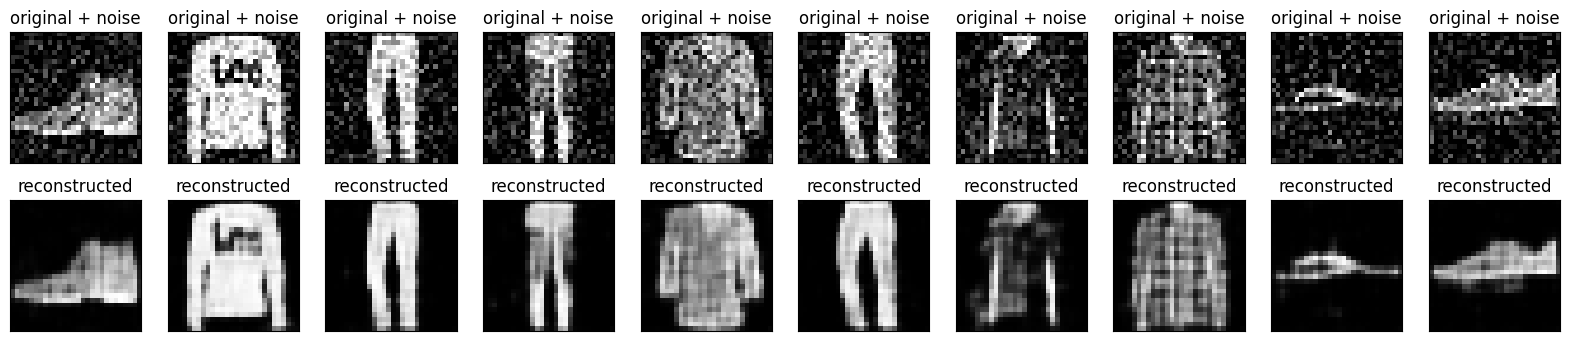

In [27]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

---

# Anomaly detection using AutoEncoder architecture

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [38]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


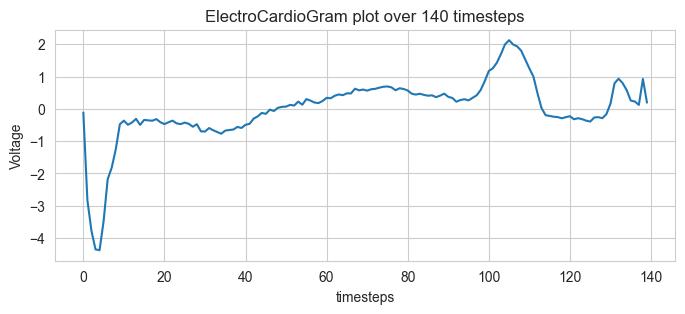

In [69]:
import seaborn as sns

def plot_ecg(timeseries):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(8, 3), dpi=100)
    
    sns.lineplot(data=timeseries, ax=ax)
    
    ax.set_title("ElectroCardioGram plot over 140 timesteps")
    ax.set_xlabel("timesteps")
    ax.set_ylabel("Voltage")
    plt.show()

plot_ecg(raw_data[0, :-1])

In [62]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

**Normalize the data to `[0,1]`.**


In [63]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [64]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

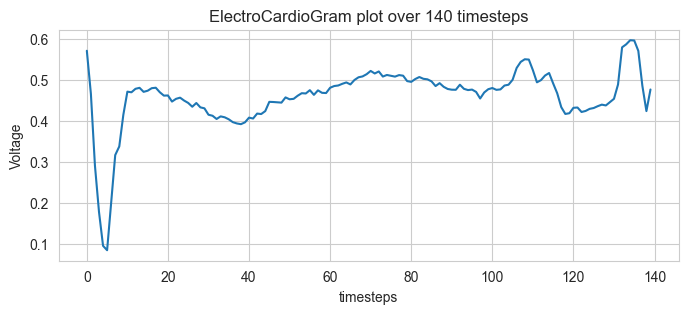

In [70]:
plot_ecg(normal_train_data[0])

Plot an anomalous ECG.

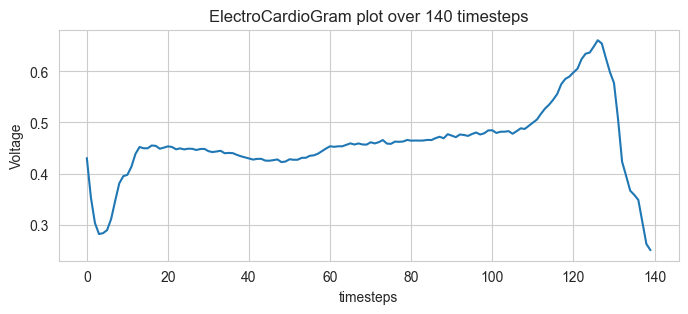

In [72]:
plot_ecg(anomalous_train_data[0])

### Build the model

In [ ]:
layers.Dense()

In [85]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [86]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [87]:
history = autoencoder.fit(normal_train_data, 
                          normal_train_data,
                          epochs=20,
                          batch_size=128,
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0556 - val_loss: 0.0469
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0410 - val_loss: 0.0396
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0287 - val_loss: 0.0358
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0241 - val_loss: 0.0337
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0220 - val_loss: 0.0326
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205 - val_loss: 0.0315
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0196 - val_loss: 0.0311
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 - val_loss: 0.0302
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0191 - val_loss: 0.0295
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0186 - val_loss: 0.0292
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185 - val_loss: 0.0286
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0178 - val_

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0576

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0573 - val_loss: 0.0528


Epoch 3/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0562

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0559 - val_loss: 0.0516


Epoch 4/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0549

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0544 - val_loss: 0.0503


Epoch 5/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0529

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0522 - val_loss: 0.0486


Epoch 6/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0495

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0488 - val_loss: 0.0470


Epoch 7/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0457

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0446 - val_loss: 0.0454


Epoch 8/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0413

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0407 - val_loss: 0.0433


Epoch 9/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0380

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0373 - val_loss: 0.0417


Epoch 10/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0349

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0344 - val_loss: 0.0410


Epoch 11/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0325

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0321 - val_loss: 0.0397


Epoch 12/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0303

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0302 - val_loss: 0.0389


Epoch 13/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0290

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0287 - val_loss: 0.0381


Epoch 14/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0280

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0275 - val_loss: 0.0372


Epoch 15/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0267

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0264 - val_loss: 0.0366


Epoch 16/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0262

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0256 - val_loss: 0.0358


Epoch 17/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0251

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - val_loss: 0.0353


Epoch 18/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0244

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0243 - val_loss: 0.0348


Epoch 19/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0238

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0236 - val_loss: 0.0344


Epoch 20/20


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0226

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0228 - val_loss: 0.0340


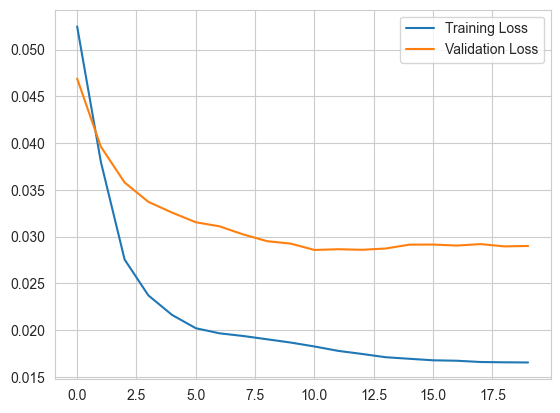

In [88]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

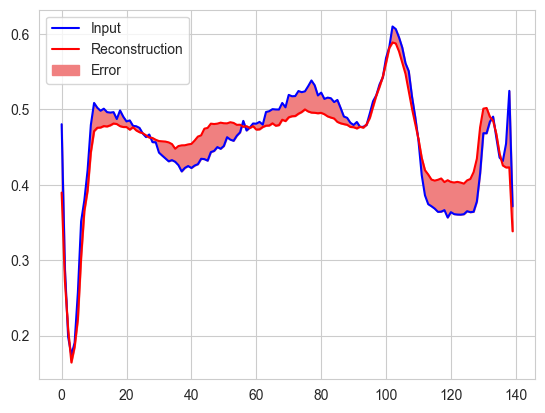

In [89]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

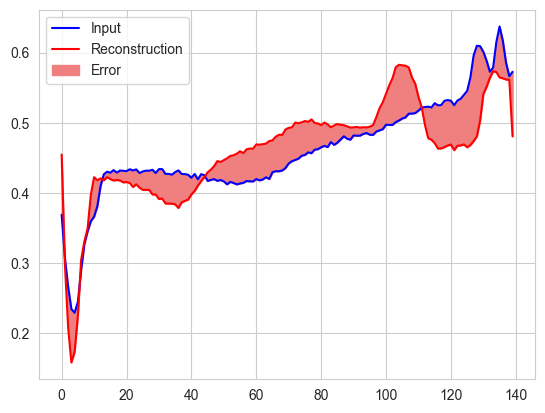

In [90]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


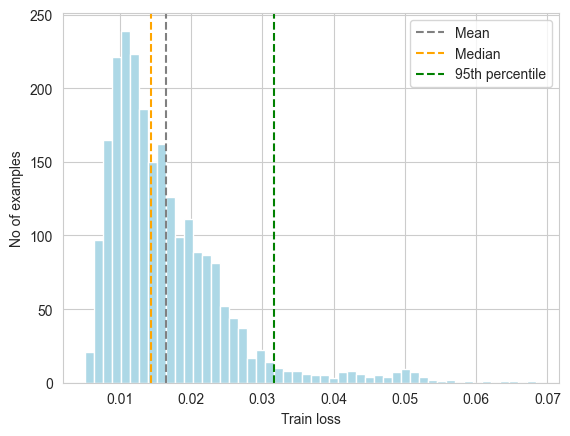

In [108]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

percentile = np.percentile(train_loss, 95)
mean = np.mean(train_loss)
median = np.percentile(train_loss, 50)

plt.hist(train_loss[None,:], bins=50, color="lightblue")
plt.axvline(x=mean, color='gray', linestyle='dashed', label='Mean')
plt.axvline(x=median, color='orange', linestyle='dashed', label='Median')
plt.axvline(x=percentile, color='green', linestyle='dashed', label='95th percentile')         
         
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.legend()
         
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [119]:
threshold = np.percentile(train_loss, 95)
print("Threshold: ", threshold)

Threshold:  0.03156523667275905


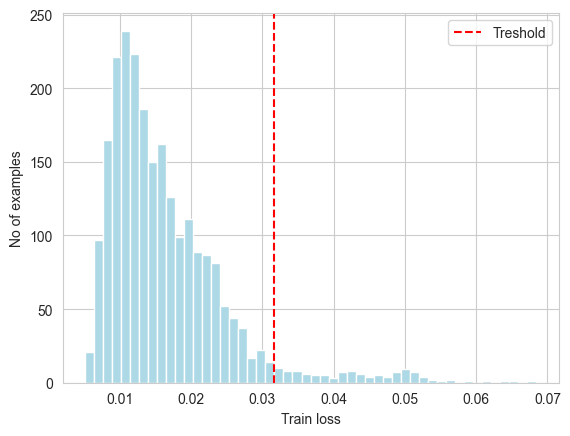

In [120]:
plt.hist(train_loss[None,:], bins=50, color="lightblue")
plt.axvline(x=threshold, color='red', linestyle='dashed', label='Treshold')

plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.legend()
         
plt.show()

Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


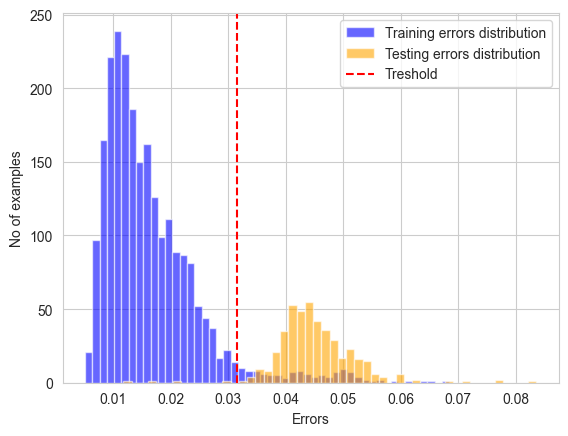

In [130]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(train_loss[None, :], bins=50, color="blue", alpha=0.6, label="Training errors distribution")
plt.hist(test_loss[None, :], bins=50, color="orange", alpha=0.6, label="Testing errors distribution")
plt.xlabel("Errors")
plt.ylabel("No of examples")
plt.axvline(x=threshold, color='red', linestyle='dashed', label='Treshold')

plt.legend()
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [122]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [123]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.971
Precision = 0.9925788497217068
Recall = 0.9553571428571429


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
